<a href="https://colab.research.google.com/github/pseudope/2021_F_Level2/blob/main/Sessions/20210924_Leve2_Seq2Seq_BLEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

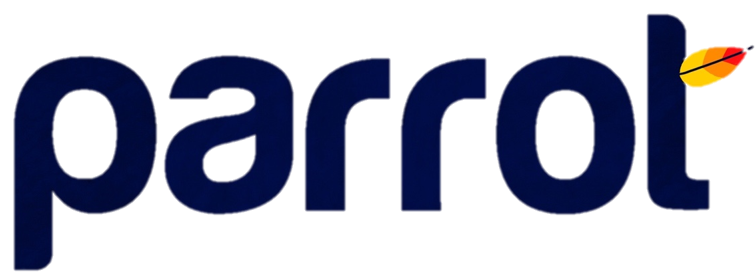

# 20210924 (Seq2Seq, BLEU)

5기 Level 2 Seq2Seq, BLEU 자료입니다.

# Contents

1. Seq2Seq
2. 실습 1 (Chracter Level)
3. 실습 2 (Word Level)
4. BLEU Score

In [ ]:
#!/usr/bin/env python3

from pprint import pprint

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Seq2Seq

Sequence-to-Sequence(이하 Seq2Seq)는 입력된 sequence로부터 다른 domain의 sequence를 출력하는 분야에서 사용되는 model입니다. Seq2Seq는 인코더(encoder)와 디코더(decoder)로 구성됩니다. 그리고 이 둘은 각각 하나의 RNN(혹은 LSTM, GRU 등) 셀로 구현됩니다.

* 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터(context vector)로 만듭니다.
* 인코더가 디코더로 context vector를 전송하면, 디코더는 이를 받아서 번역된 단어를 한 개씩 순차적으로 출력합니다.

<p align="center">
  <img src="https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG" alt="text"/> </p>

이러한 병렬 코퍼스 데이터의 경우, 앞서 학습한 tagging과는 달리 데이터 간의 일대일 대응이 이루어지지 않을 수 있습니다. 즉, input sequence의 길이와 output sequence의 길이가 서로 다를 수 있습니다.

- 예시 $1$ (기계번역): 프랑스어에서는 직업 앞에 관사(un, une, le, la, les 등)를 붙이지 않습니다. 따라서 "I am a student"라는 token의 수가 4개인 input을 넣으면, "Je suis étudiant(e)"(이)라는 token의 수가 3개인 output이 나오게 됩니다. 

<p align="center">
  <img src="https://wikidocs.net/images/page/24996/seq2seq%EB%AA%A8%EB%8D%B811.PNG" alt="text"/> </p>

- 예시 $2$ (챗봇): 질문의 길이와 답변의 길이가 일치해야 할 필요는 당연히 없습니다.<br>
Q)오늘 저녁 치킨 고? A)좋아!

# 2. 실습 1 (Character Level)

## Preparing Dataset

In [ ]:
df = pd.read_csv(path, names=["src", "tar", "lic"], sep="\t")
del df["lic"]

df

src  \
0                                                     Go.   
1                                                     Go.   
2                                                     Go.   
3                                                     Hi.   
4                                                     Hi.   
5                                                    Run!   
6                                                    Run!   
7                                                    Run!   
8                                                    Run!   
9                                                    Run!   
10                                                   Run!   
11                                                   Run!   
12                                                   Run!   
13                                                   Run.   
14                                                   Run.   
15                                                   Run.   
16                                                   Run.   
17                                                   Run.   
18                                                   Run.   
19                                                   Run.   
20                                                   Run.   
21                                                   Who?   
22                                                   Wow!   
23                                                  Duck!   
24                                                  Duck!   
25                                                  Duck!   
26                                                  Fire!   
27                                                  Help!   
28                                                  Hide.   
29                                                  Hide.   
...                                                   ...   
190176  What is old age? First you forget names, then ...   
190177  He and I have a near-telepathic understanding ...   
190178  Although rainforests make up only two percent ...   
190179  She has a boyfriend she's been going out with ...   
190180  If you take a child outside and point at the m...   
190181  If you translate from your second language int...   
190182  I love trying out new things, so I always buy ...   
190183  A good theory is characterized by the fact tha...   
190184  An Earth-like planet, which is believed to hav...   
190185  The more time you spend speaking a foreign lan...   
190186  The enquiry concluded that, despite his denial...   
190187  Roger Miller's father died when he was only on...   
190188  The Tatoeba Project, which can be found online...   
190189  You may not learn to speak as well as a native...   
190190  And the good news is that today the economy is...   
190191  E-cigarettes are being promoted as a healthy a...   
190192  It's still too hard to find a job. And even if...   
190193  As you contribute more sentences to the Tatoeb...   
190194  Even at the end of the nineteenth century, sai...   
190195  Five tremors in excess of magnitude 5.0 on the...   
190196  No matter how much you try to convince people ...   
190197  A child who is a native speaker usually knows ...   
190198  There are four main causes of alcohol-related ...   
190199  We need to uphold laws against discrimination ...   
190200  Top-down economics never works, said Obama. "T...   
190201  A carbon footprint is the amount of carbon dio...   
190202  Death is something that we're often discourage...   
190203  Since there are usually multiple websites on a...   
190204  If someone who doesn't know your background sa...   
190205  It may be impossible to get a completely error...   

                                                      tar  
0                                                    Va !  
1                                                 Marche.  
2                                                 Bouge !  
3                              

## Preprocessing

현재 character level에서 하기 때문에, $\text{<sos>}$를 넣으면 <, s, o > 각각을 인식하고, 마찬가지로 $\text{<eos>}$를 넣으면 <, e, o, s, > 각각을 인식합니다. 따라서 불가피하게 $\text{<sos>}$를 "/t"로, $\text{<eos>}$를 "/n"으로 대체하여 수행합니다.

In [ ]:
df.tar = df.tar.apply(lambda sentence : "\t "+ sentence + " \n")
df.sample(10)

src  \
29512                  I won't let you in.   
83600          He's addicted to junk food.   
56223              Is this time different?   
29206                  I often wear a hat.   
131774  I'm sure Tom will know what to do.   
29550                  I'll give it a try.   
5607                         Stop pushing.   
85536          I'm doing a lot of reading.   
104043       Your paintings are beautiful.   
100980       My plan is working perfectly.   

                                                tar  
29512        \t Je ne vous laisserai pas entrer. \n  
83600            \t Il est accro à la malbouffe. \n  
56223    \t En va-t-il différemment cette fois ? \n  
29206            \t Je porte souvent un chapeau. \n  
131774  \t Je suis sûr que Tom saura quoi faire. \n  
29550                      \t Je ferai un essai. \n  
5607                       \t Cessez de pousser. \n  
85536                        \t Je lis beaucoup. \n  
104043               \t Vos tableaux sont beaux. \n  
100980   \t Mon plan se déroule à la perfection. \n

In [ ]:
### 글자 집합 구축

src_vocab = set()
for sentence in df.src: # 1줄씩 읽음
    for char in sentence: # 1개의 글자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for sentence in df.tar: # 1줄씩 읽음
    for char in sentence: # 1개의 글자씩 읽음
        tar_vocab.add(char)

In [ ]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print(src_vocab_size)
print(tar_vocab_size)

90
116


## Indexing

In [ ]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{'K': 1, 'é': 2, 'A': 3, 'V': 4, 'Y': 5, 'f': 6, 'e': 7, '-': 8, 'U': 9, 'I': 10, 's': 11, 'ö': 12, 'Q': 13, 'G': 14, 'O': 15, ' ': 16, '7': 17, ',': 18, 'g': 19, 'c': 20, 'u': 21, 'l': 22, 'r': 23, '6': 24, 'º': 25, '–': 26, '&': 27, '₂': 28, '‘': 29, ':': 30, '2': 31, 't': 32, '%': 33, '\xa0': 34, 'x': 35, 'S': 36, '+': 37, 'm': 38, '\xad': 39, 'R': 40, 'z': 41, '4': 42, 'y': 43, 'X': 44, '8': 45, '!': 46, 'i': 47, '—': 48, 'J': 49, 'n': 50, '$': 51, '0': 52, 'L': 53, '’': 54, 'v': 55, "'": 56, 'b': 57, '?': 58, 'T': 59, 'H': 60, 'E': 61, 'o': 62, 'q': 63, '3': 64, '"': 65, 'd': 66, 'Z': 67, '9': 68, 'F': 69, '€': 70, 'w': 71, 'ú': 72, 'k': 73, 'p': 74, ';': 75, 'C': 76, '.': 77, 'B': 78, '5': 79, '1': 80, 'N': 81, 'W': 82, 'a': 83, 'h': 84, 'P': 85, 'j': 86, 'D': 87, 'M': 88, '/': 89}
{'K': 1, 'é': 2, 'à': 3, 'A': 4, 'V': 5, 'Y': 6, 'f': 7, 'e': 8, '-': 9, 'U': 10, 'I': 11, '»': 12, 'Ô': 13, 's': 14, 'ö': 15, 'Q': 16, 'â': 17, 'G': 18, 'O': 19, ' ': 20, 'ô': 21, 'ç': 22, '\n': 23, '

In [ ]:
encoder_input = []
for sentence in df.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for word in sentence: #각 줄에서 1개씩 글자를 읽음
        temp_X.append(src_to_index[word]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)

decoder_input = []
for sentence in df.tar:
    temp_X = []
    for word in sentence:
        temp_X.append(tar_to_index[word])
    decoder_input.append(temp_X)

In [ ]:
decoder_target = []

for sentence in df.tar:
    t = 0
    temp_X = []
    for word in sentence:
        if t > 0:
            temp_X.append(tar_to_index[word])
        t = t + 1
    decoder_target.append(temp_X)

## Padding

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
import matplotlib.pyplot as plt

print('문장의 최대 길이 :',max(len(l) for l in df.src))
print('문장의 평균 길이 :',sum(map(len, df.src))/len(df.src))
plt.hist([len(s) for s in df.src], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

문장의 최대 길이 : 286
문장의 평균 길이 : 30.34418998349158


<Figure size 640x480 with 1 Axes>

In [ ]:
max_len_src = 71
below_threshold_len(max_len_src, df.src)

전체 샘플 중 길이가 71 이하인 샘플의 비율: 99.00634049399073


문장의 최대 길이 : 353
문장의 평균 길이 : 39.85617698705614


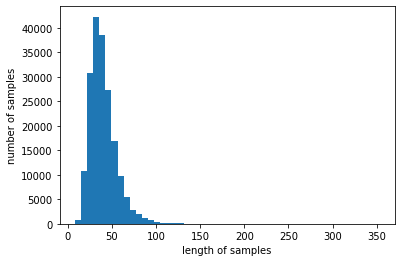

In [ ]:
import matplotlib.pyplot as plt

print('문장의 최대 길이 :',max(len(l) for l in df.tar))
print('문장의 평균 길이 :',sum(map(len, df.tar))/len(df.tar))
plt.hist([len(s) for s in df.tar], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len_tar = 98
below_threshold_len(max_len_tar, df.tar)

전체 샘플 중 길이가 98 이하인 샘플의 비율: 99.45743036497271


인코더의 차원과 디코더의 차원을 맞출 필요는 없습니다. 각각 71차원, 98차원으로 padding하겠습니다. 또한, character level의 분석이기 때문에 별도의 word embedding은 진행하지 않습니다.

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen=max_len_src, padding="post")
decoder_input = pad_sequences(decoder_input, maxlen=max_len_tar, padding="post")
decoder_target = pad_sequences(decoder_target, maxlen=max_len_tar, padding="post")

In [ ]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## Q) 디코더의 input은 왜 필요한가요? 인코더의 output이 디코더의 input일텐데?

A) 만약 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용한다면, 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높을 것입니다. 또한, 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 할 것이며, 이런 상황이 반복되면 훈련 시간이 느려지거나 원하는 학습 결과를 얻지 못하게 될 것입니다. 이를 방지하고자 이전 시점의 디코더 셀의 예측값 대신 실제값(ground truth)을 현재 시점의 디코더 셀의 입력으로 사용하는 방법이 제안되었고, 이를 Teacher Forcing이라고 부릅니다. <br>

물론, 이러한 기법은 biased된 model을 만들 수도 있다는 단점을 가지고 있습니다. training 때와는 달리, forecasting 때에는 이러한 기법을 사용할 수 없을텐데, Teacher Forcing에 기반한 model은 pool 밖에 있는 noisy data를 학습한 경험이 없기 때문입니다. 이는 결과적으로 forecasting 능력의 저하로 이어질 수밖에 없습니다. 하지만 다행히도 최근들어 다음과 같은 논문들이 이러한 biased가 생각보다 결과에 큰 영향을 주지는 않는다고 이야기하고 있어서, 우리는 의심없이 Teacher Forcing을 training 시에 적용할 것입니다. <br>

https://arxiv.org/pdf/1905.10617.pdf

## Training

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam

encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True,
                    dropout=0.2, recurrent_dropout=0.15)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c] # LSTM은 바닐라 RNN과는 달리 상태가 두 개

decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True,
                   dropout=0.2, recurrent_dropout=0.15)

# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation="softmax")
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 90)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 116)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 355328      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  381952      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [ ]:
lr_Cosine_Decay = CosineDecayRestarts(
    initial_learning_rate=(5e-4), first_decay_steps=152164,
    t_mul=2, m_mul=0.75, alpha=0.0, name=None
)

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=128, epochs=63, validation_split=0.2)

Train on 152164 samples, validate on 38042 samples
Epoch 1/63
152164/152164 [==============================] - 216s 1ms/sample - loss: 0.9283 - accuracy: 0.7563 - val_loss: 1.3545 - val_accuracy: 0.6170
Epoch 2/63
152164/152164 [==============================] - 216s 1ms/sample - loss: 0.6889 - accuracy: 0.7980 - val_loss: 1.2384 - val_accuracy: 0.6487
Epoch 3/63
152164/152164 [==============================] - 217s 1ms/sample - loss: 0.6334 - accuracy: 0.8121 - val_loss: 1.1685 - val_accuracy: 0.6722
Epoch 4/63
152164/152164 [==============================] - 218s 1ms/sample - loss: 0.5871 - accuracy: 0.8247 - val_loss: 1.0993 - val_accuracy: 0.6940
Epoch 5/63
152164/152164 [==============================] - 217s 1ms/sample - loss: 0.5481 - accuracy: 0.8356 - val_loss: 1.0476 - val_accuracy: 0.7114
Epoch 6/63
152164/152164 [==============================] - 217s 1ms/sample - loss: 0.5185 - accuracy: 0.8439 - val_loss: 1.0083 - val_accuracy: 0.7244
Epoch 7/63
152164/152164 [===========

In [ ]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

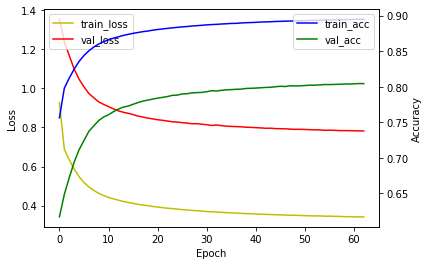

In [ ]:
acc_loss_plot(history)

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
decoder_states = [state_h, state_c]

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index["\t"]] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_len_tar):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', df.src[seq_index])
    print('정답 문장:', df.tar[seq_index][1:len(df.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Hi.
정답 문장:  Salut ! 
번역기가 번역한 문장:  Soyez ! 
-----------------------------------
입력 문장: I see.
정답 문장:  Aha. 
번역기가 번역한 문장:  Je me sens des enfants. 
-----------------------------------
입력 문장: Hug me.
정답 문장:  Serrez-moi dans vos bras ! 
번역기가 번역한 문장:  Aide-moi ! 
-----------------------------------
입력 문장: Hold it!
정답 문장:  Restez où vous êtes ! 
번역기가 번역한 문장:  Attendez-le. 
-----------------------------------
입력 문장: I crashed.
정답 문장:  Je me suis écrasée. 
번역기가 번역한 문장:  J'ai pris un moment. 


# 3. 실습 2 (Word Level)

## Preparing Dataset

In [ ]:
import unicodedata
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(path, names=["src", "tar", "lic"], sep="\t")
del df["lic"]

df

src  \
0                                                     Go.   
1                                                     Go.   
2                                                     Go.   
3                                                     Hi.   
4                                                     Hi.   
5                                                    Run!   
6                                                    Run!   
7                                                    Run!   
8                                                    Run!   
9                                                    Run!   
10                                                   Run!   
11                                                   Run!   
12                                                   Run!   
13                                                   Run.   
14                                                   Run.   
15                                                   Run.   
16                                                   Run.   
17                                                   Run.   
18                                                   Run.   
19                                                   Run.   
20                                                   Run.   
21                                                   Who?   
22                                                   Wow!   
23                                                  Duck!   
24                                                  Duck!   
25                                                  Duck!   
26                                                  Fire!   
27                                                  Help!   
28                                                  Hide.   
29                                                  Hide.   
...                                                   ...   
190176  What is old age? First you forget names, then ...   
190177  He and I have a near-telepathic understanding ...   
190178  Although rainforests make up only two percent ...   
190179  She has a boyfriend she's been going out with ...   
190180  If you take a child outside and point at the m...   
190181  If you translate from your second language int...   
190182  I love trying out new things, so I always buy ...   
190183  A good theory is characterized by the fact tha...   
190184  An Earth-like planet, which is believed to hav...   
190185  The more time you spend speaking a foreign lan...   
190186  The enquiry concluded that, despite his denial...   
190187  Roger Miller's father died when he was only on...   
190188  The Tatoeba Project, which can be found online...   
190189  You may not learn to speak as well as a native...   
190190  And the good news is that today the economy is...   
190191  E-cigarettes are being promoted as a healthy a...   
190192  It's still too hard to find a job. And even if...   
190193  As you contribute more sentences to the Tatoeb...   
190194  Even at the end of the nineteenth century, sai...   
190195  Five tremors in excess of magnitude 5.0 on the...   
190196  No matter how much you try to convince people ...   
190197  A child who is a native speaker usually knows ...   
190198  There are four main causes of alcohol-related ...   
190199  We need to uphold laws against discrimination ...   
190200  Top-down economics never works, said Obama. "T...   
190201  A carbon footprint is the amount of carbon dio...   
190202  Death is something that we're often discourage...   
190203  Since there are usually multiple websites on a...   
190204  If someone who doesn't know your background sa...   
190205  It may be impossible to get a completely error...   

                                                      tar  
0                                                    Va !  
1                                                 Marche.  
2                                                 Bouge !  
3                              

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

## Preprocessing

In [ ]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open(path, "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split("\t")

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

    return encoder_input, decoder_input, decoder_target

In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


In [ ]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [ ]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

In [ ]:
print(encoder_input.shape)

(190206, 50)


In [ ]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 14823, 프랑스어 단어 집합의 크기 : 24010


In [ ]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(encoder_input.shape[0]*0.1)
print(n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

19020


In [ ]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(171186, 50)
(171186, 62)
(171186, 62)
(19020, 50)
(19020, 62)
(19020, 62)


## Modeling

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
latent_dim = 50

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     741150      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 50)     1200500     input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
lr_Cosine_Decay = CosineDecayRestarts(
    initial_learning_rate=(5e-4), first_decay_steps=171186,
    t_mul=2, m_mul=0.75, alpha=0.0, name=None
)

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 256, epochs = 63)

Train on 171186 samples, validate on 19020 samples
Epoch 1/63
171186/171186 [==============================] - 157s 915us/sample - loss: 2.3080 - accuracy: 0.8489 - val_loss: 0.8719 - val_accuracy: 0.8532
Epoch 2/63
171186/171186 [==============================] - 145s 845us/sample - loss: 0.8157 - accuracy: 0.8670 - val_loss: 0.7754 - val_accuracy: 0.8767
Epoch 3/63
171186/171186 [==============================] - 145s 847us/sample - loss: 0.7447 - accuracy: 0.8855 - val_loss: 0.7152 - val_accuracy: 0.8908
Epoch 4/63
171186/171186 [==============================] - 145s 845us/sample - loss: 0.6955 - accuracy: 0.8922 - val_loss: 0.6796 - val_accuracy: 0.8935
Epoch 5/63
171186/171186 [==============================] - 145s 846us/sample - loss: 0.6671 - accuracy: 0.8941 - val_loss: 0.6586 - val_accuracy: 0.8948
Epoch 6/63
171186/171186 [==============================] - 145s 848us/sample - loss: 0.6462 - accuracy: 0.8959 - val_loss: 0.6378 - val_accuracy: 0.8970
Epoch 7/63
171186/171186 

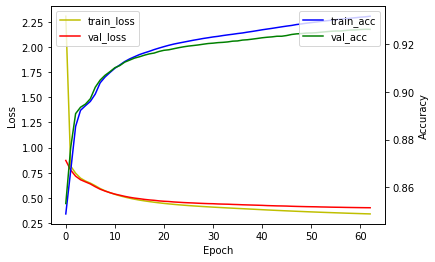

In [ ]:
acc_loss_plot(history)

## Forecasting

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [ ]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == "<eos>" or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index["<sos>"]) and i!=tar_to_index["<eos>"]):
            temp = temp + index_to_tar[i] + ' '
    return temp

### train data에 대한 forecasting

In [ ]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(encoder_input_train[seq_index]))
    print("번역문 :",seq2tar(decoder_input_train[seq_index]))
    print("예측문 :",decoded_sentence[:-5])
    print("\n")

원문 :  i just didn t want you in here . 
번역문 : je ne voulais simplement pas que tu fusses ici . 
예측문 :  je ne veux pas que vous avez fait ca . 


원문 :  i have to climb this mountain . 
번역문 : je dois gravir cette montagne . 
예측문 :  je dois le faire une bonne memoire . 


원문 :  you re not allowed to swim here . 
번역문 : tu n es pas autorisee a nager ici . 
예측문 :  tu ne peux pas le faire comme ca a l heure . 


원문 :  there was no response . 
번역문 : il n y eut pas de reponse . 
예측문 :  il n y a pas de reponse . 


원문 :  luck plays an important part in life . 
번역문 : la chance joue un role important dans la vie . 
예측문 :  la maison est un peu de la guerre mondiale . 




### test data에 대한 forecasting

In [ ]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(encoder_input_test[seq_index]))
    print("번역문 :",seq2tar(decoder_input_test[seq_index]))
    print("예측문 :",decoded_sentence[:-5])
    print("\n")

원문 :  we received their wedding announcement . 
번역문 : nous avons recu leur faire part de mariage . 
예측문 :  nous avons fait un livre . 


원문 :  you re disgusting . 
번역문 : vous etes degoutant . 
예측문 :  vous etes en train de faire . 


원문 :  i appreciate the support . 
번역문 : je suis reconnaissant pour ton soutien . 
예측문 :  je suis desole . 


원문 :  one store decided to pull the controversial cd from its shelves . 
번역문 : un magasin decida de retirer le cd controverse de ses etageres . 
예측문 :  la porte de la population de neige a la capita


원문 :  i quite agree . 
번역문 : je suis tout a fait d accord . 
예측문 :  je suis en train de faire une fois . 




# 4. BLEU (BiLingual Evaluation Understudy)

해당 내용은 김동화님의 GitHub Blog의 내용을 적극 참조하였습니다.

(주소: https://donghwa-kim.github.io/BLEU.html)

BLEU(Bilingual Evaluation Understudy)는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. n-gram size를 1부터 4까지 고려하여 측정하며, precision에 관하여만 측정합니다. BLEU는 언어에 구애받지 않고 사용할 수 있으며, 계산 속도가 빠르다는 장점을 가지고 있습니다.

BLEU의 계산 식은 다음과 같습니다. (BLEU는 높을수록 성능이 더 좋음을 의미합니다.)

$$\text{BLEU} = min(1, \frac{\text{length of prediction}}{\text{length of reference}}) \times (\prod^{4}_{i=1} \text{precision}_i)^{\frac{1}{4}}$$

BLEU는 다음 세 가지에 기반하여 계산됩니다.
* 1-gram ~ 4-gram 각각에서 얼마나 겹치는지 측정(precision)
* 단어 중복 보정(clipping)
* 문장 길이 보정(Brevity Penalty)

다음 문장을 예시로 삼아 직접 계산을 해봅시다.

"I meant to write you sooner but I just been busy." - Eminem, Stan

## 4-1. Precision

Reference: **I**  meant **to** write **you** **sooner** **but** **I** just been **busy**. <br>
Prediction: **I** wanted **to** meet **you** **sooner** **but** **I** was so 
**busy**.

$$\text{1-gram Precision}: \frac{7}{11}$$
$$\text{2-gram Precision}: \frac{3}{10}$$
$$\text{3-gram Precision}: \frac{2}{9}$$
$$\text{4-gram Precision}: \frac{1}{8}$$

따라서, $(\prod^{4}_{i=1} \text{precision}_i)^{\frac{1}{4}} = (\frac{7} {11} \times \frac{3} {10} \times \frac{2} {9} \times \frac{1} {8})^{\frac{1} {4}} \approx 0.27$

## 4-2. Clipping

같은 단어가 여러 번 등장할 경우, reference(true sentence)에 나온 만큼만 허용하여 counting을 합니다. 즉, 예시 문장에서 **I**는 총 2회 나오므로, Prediction에서 아무리 많이 **I**가 등장하더라도, 2회가 넘어가면 그냥 2회로 counting합니다.

## 4-3. Brevity Penalty

그저 문장이 길어져서 좋은 결과가 나옴을 방지하기 위하여(혹은 reference가 다소 짧은 문장일 때를 대비하여), $min(1, \cdot)$ 함수를 이용합니다.

## 4-4. 실습

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [ ]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(encoder_input_test[seq_index]))
    print("번역문 :",seq2tar(decoder_input_test[seq_index]))
    print("예측문 :",decoded_sentence[:-5])
    
    bleu_score = sentence_bleu(seq2tar(decoder_input_test[seq_index]).split(),
                               decoded_sentence[:-5].split(),
                               smoothing_function=SmoothingFunction().method4)
    
    print("BLEU SCORE: {0:.4f}".format(bleu_score))
    print("\n")

원문 :  we received their wedding announcement . 
번역문 : nous avons recu leur faire part de mariage . 
예측문 :  nous avons fait un livre . 
BLEU SCORE: 0.1995


원문 :  you re disgusting . 
번역문 : vous etes degoutant . 
예측문 :  vous etes en train de faire . 
BLEU SCORE: 0.1496


원문 :  i appreciate the support . 
번역문 : je suis reconnaissant pour ton soutien . 
예측문 :  je suis desole . 
BLEU SCORE: 0.1956


원문 :  one store decided to pull the controversial cd from its shelves . 
번역문 : un magasin decida de retirer le cd controverse de ses etageres . 
예측문 :  la porte de la population de neige a la capita
BLEU SCORE: 0.1769


원문 :  i quite agree . 
번역문 : je suis tout a fait d accord . 
예측문 :  je suis en train de faire une fois . 
BLEU SCORE: 0.1969


